<img
    src="https://upload.wikimedia.org/wikipedia/de/f/fe/Airbus_Logo.svg" width="600" height="490" style="display: block;
  margin-left: auto;
  margin-right: auto" />

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

## 1) Importing libraries

In [2]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
from matplotlib import pyplot as plt, dates
import seaborn as sns
from datetime import datetime
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

## 2) Loading data

The dataset contains simulated leaks of 5kg/s, 1kg/s and 0.5kg/s.

In [3]:
# Download the dataset
#final = pd.read_csv("/content/drive/MyDrive/Uni/IE/Capstone/dataset_autoencoder_with_fuel_leak_resampled.csv", sep=',')
final = pd.read_csv("generated_data/dataset_autoencoder_with_fuel_leak_resampled.csv", sep=',')
final

,FUEL_USED_1,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,FW_GEO_ALTITUDE,VALUE_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,...,FLIGHT,TOTAL_FUEL_USED,VALUE_FOB_DIFF,TOTAL_FOB_BY_QTY,DELTA_VFOB_VS_VFOBQTY,ALTITUDE_DIFF,VALUE_FOB_MISSING,VALUE_FOB_MISSING_BY_QTY,VALUE_FOB_BY_FUEL_USED,label
0,155.744975,154.661250,152.905900,150.077375,3008.56850,22643.25,0.0,1842.00,2556.50,2597.25,...,2.0,613.389500,-5.50,22646.0,-2.75,20.56675,69.75,61.0,22099.610500,0.0
1,158.475560,157.385020,155.620860,152.839420,3157.07820,22628.20,0.0,1839.20,2570.00,2616.20,...,2.0,624.320860,-0.60,22631.0,-2.80,27.94520,84.80,76.0,22088.679140,0.0
2,160.995400,159.870920,158.076460,155.339320,3283.94220,22628.20,0.0,1838.20,2585.80,2631.40,...,2.0,634.282100,0.80,22631.4,-3.20,23.38660,84.80,75.6,22078.717900,0.0
3,163.354250,162.208350,160.412150,157.717475,3391.20725,22631.75,0.0,1837.75,2602.25,2644.25,...,2.0,643.692225,1.75,22634.5,-2.75,22.83350,81.25,72.5,22069.307775,0.0
4,165.982500,164.822925,162.983350,160.341150,3497.44875,22633.25,0.0,1837.00,2619.75,2657.75,...,2.0,654.129925,0.75,22637.0,-3.75,18.66800,79.75,70.0,22058.870075,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51915,3812.429932,3814.106836,3858.093262,3869.840283,31982.60000,24561.80,47.0,1847.20,2597.00,2652.00,...,6939.0,15354.470312,-7.20,24565.0,-3.20,2.00000,848.20,846.0,10055.529688,1.0
51916,3813.984326,3815.687402,3859.675195,3871.436426,31979.80000,24530.00,48.0,1845.80,2594.80,2650.40,...,6939.0,15360.783350,-6.00,24532.0,-2.00,0.80000,880.00,879.0,10049.216650,1.0
51917,3815.558350,3817.233594,3861.262549,3873.028906,31978.60000,24502.00,49.2,1843.80,2593.00,2650.60,...,6939.0,15367.083398,-5.00,24504.4,-2.40,1.80000,908.00,906.6,10042.916602,1.0
51918,3817.105664,3818.788037,3862.828857,3874.617285,31978.40000,24472.60,46.2,1840.40,2589.40,2651.60,...,6939.0,15373.339844,-7.40,24474.6,-2.00,2.60000,937.40,936.4,10036.660156,1.0


In [4]:
dataset = final.copy()
dataset = dataset.dropna()

## 3) Feature selection

We decided to combine all the fuel used and all the fuel tank quantities into 2 features to simplify our model.

In [5]:
def add_features(dataset):
  dataset['TOTAL_FUEL_USED'] = dataset['FUEL_USED_1'] +  dataset['FUEL_USED_2'] +  dataset['FUEL_USED_3'] +  dataset['FUEL_USED_4']
  dataset['TOTAL_FOB_BY_QTY'] = dataset['VALUE_FUEL_QTY_CT'] + dataset['VALUE_FUEL_QTY_FT1'] + dataset['VALUE_FUEL_QTY_FT2'] + dataset['VALUE_FUEL_QTY_FT3'] + dataset['VALUE_FUEL_QTY_FT4'] + dataset['VALUE_FUEL_QTY_LXT'] + dataset['VALUE_FUEL_QTY_RXT']
  return dataset

def drop_features(dataset):
    dataset = dataset.drop(['FUEL_USED_1','FUEL_USED_2','FUEL_USED_3','FUEL_USED_4','VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3','VALUE_FUEL_QTY_FT4', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT'], 1)
    return dataset

In [6]:
dataset = add_features(dataset)
dataset = drop_features(dataset)

/var/folders/jz/7k4lz9z91w92yqvc2ffzy2b80000gn/T/ipykernel_9720/3407511113.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset = dataset.drop(['FUEL_USED_1','FUEL_USED_2','FUEL_USED_3','FUEL_USED_4','VALUE_FUEL_QTY_CT', 'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3','VALUE_FUEL_QTY_FT4', 'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT'], 1)


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51920 entries, 0 to 51919
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   FW_GEO_ALTITUDE           51920 non-null  float64
 1   VALUE_FOB                 51920 non-null  float64
 2   FLIGHT                    51920 non-null  float64
 3   TOTAL_FUEL_USED           51920 non-null  float64
 4   VALUE_FOB_DIFF            51920 non-null  float64
 5   TOTAL_FOB_BY_QTY          51920 non-null  float64
 6   DELTA_VFOB_VS_VFOBQTY     51920 non-null  float64
 7   ALTITUDE_DIFF             51920 non-null  float64
 8   VALUE_FOB_MISSING         51920 non-null  float64
 9   VALUE_FOB_MISSING_BY_QTY  51920 non-null  float64
 10  VALUE_FOB_BY_FUEL_USED    51920 non-null  float64
 11  label                     51920 non-null  float64
dtypes: float64(12)
memory usage: 4.8 MB


In [8]:
dataset = dataset.drop(['FW_GEO_ALTITUDE'], axis = 1)

In [9]:
move_column1 = dataset.pop('label')

dataset.insert(10, 'LABEL', move_column1)

In [10]:
dataset["LABEL"].replace([1, 0], [0, 1], inplace=True)

In [11]:
#dataset.to_csv("airclean_data/before_autoencoding.csv", decimal=)

dataset.to_clipboard(decimal=",")

In [12]:
dataset['LABEL'].value_counts()

1.0    29746
0.0    22174
Name: LABEL, dtype: int64

In [13]:
# devide raw_data into train and test sets. by flight sequence 2/3 of the data for training and the 1/3 for testing
train = pd.DataFrame()
test = pd.DataFrame()

for flight in dataset["FLIGHT"].unique():
    flight_data = dataset[dataset["FLIGHT"] == flight]
    train = pd.concat([train, flight_data.iloc[:int(len(flight_data)*1/3)]])
    test = pd.concat([test, flight_data.iloc[int(len(flight_data)*2/3):]])

In [14]:
# raw data for train_test_split method
raw_data = dataset.values

raw_train = train.values
raw_test = test.values

## 4) Train/Test Split

In [15]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the data
data = raw_data[:, 0:-1]

# assign train set
train_data = raw_train[:, 0:-1]
train_labels = raw_train[:, -1]
 
# assign test set
test_data = raw_test[:, 0:-1] 
test_labels = raw_test[:, -1]

# train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.33, random_state=42)

In [16]:
print(train_data.shape)
print(train_labels.shape)

(16799, 10)
(16799,)


In [17]:
np.mean(train_labels)

0.5737246264658611

## 4) Normalization

In [18]:
train_data_not_normalized = train_data.copy()
test_data_not_normalized = test_data.copy()

In [19]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float64)
test_data = tf.cast(test_data, tf.float64)

In [20]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

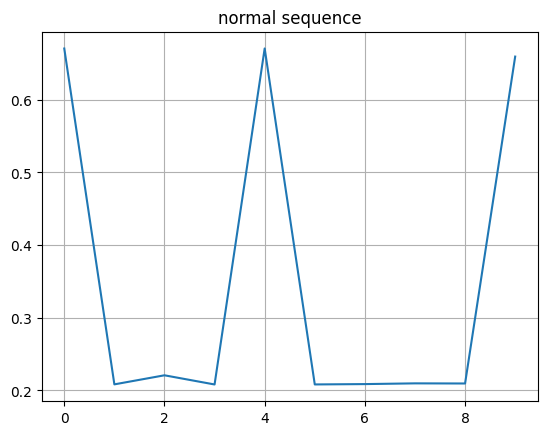

In [21]:
plt.grid()
plt.plot(np.arange(10), normal_train_data[0])
plt.title("normal sequence")
plt.show()

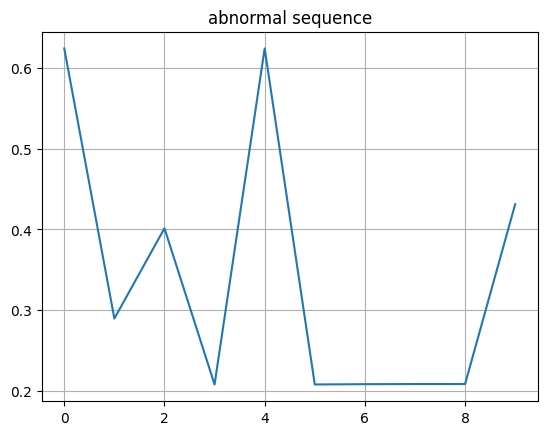

In [22]:
plt.grid()
plt.plot(np.arange(10), anomalous_train_data[0])
plt.title("abnormal sequence")
plt.show()

## 5) Autoencoder Model

In [23]:
EPOCHS = 400
BATCH_SIZE = 100
LEARNING_RATE = 1e-4

# Define the costs
cost_true_negative = 0
cost_true_positive = 0
cost_false_negative = 15  # Cost of a false negative
cost_false_positive = 10  # Cost of a false positive


def modified_cost(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    fn = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred) * tf.keras.backend.cast(tf.keras.backend.equal(y_true, 1), tf.keras.backend.floatx()))
    fp = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred) * tf.keras.backend.cast(tf.keras.backend.equal(y_true, 0), tf.keras.backend.floatx()))
    tn = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred) * tf.keras.backend.cast(tf.keras.backend.equal(y_true, 0), tf.keras.backend.floatx()))
    tp = tf.keras.backend.sum(tf.keras.backend.square(y_true - y_pred) * tf.keras.backend.cast(tf.keras.backend.equal(y_true, 1), tf.keras.backend.floatx()))
    return mse + cost_false_negative * fn + cost_false_positive * fp + cost_true_negative * tn + cost_true_positive * tp


class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(80, activation="relu"),
      layers.Dense(70, activation="relu"),
      layers.Dense(60, activation="relu"),
      layers.Dense(50, activation="relu"),
      layers.Dense(40, activation="relu"),
      layers.Dense(30, activation="relu"),
      layers.Dense(20, activation="relu"),
      layers.Dense(10, activation="relu")
      ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(20, activation="relu"),
      layers.Dense(30, activation="relu"),
      layers.Dense(40, activation="relu"),
      layers.Dense(50, activation="relu"),
      layers.Dense(60, activation="relu"),
      layers.Dense(70, activation="relu"),
      layers.Dense(80, activation="relu"),
      layers.Dense(10, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [24]:
import itertools

# Define the hyperparameters to tune
param_grid = {
    'batch_size': [128, 256],
    'epochs': [100, 200],
    'learning_rate': [1e-3, 1e-4]
}

# Perform grid search
best_loss = float('inf')
best_params = {}

for batch_size, epochs, learning_rate in itertools.product(param_grid['batch_size'], param_grid['epochs'], param_grid['learning_rate']):
    # Create an instance of the AnomalyDetector model
    autoencoder = AnomalyDetector()
    autoencoder.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss=modified_cost)

    # Train the model
    history = autoencoder.fit(normal_train_data, normal_train_data, epochs=epochs, batch_size=batch_size, validation_data=(normal_test_data, normal_test_data), shuffle=True)

    # Get the loss value
    val_loss = history.history['val_loss'][-1]

    # Check if this combination of hyperparameters resulted in a better loss
    if val_loss < best_loss:
        best_loss = val_loss
        best_params = {
            'batch_size': batch_size,
            'epochs': epochs,
            'learning_rate': learning_rate
        }

# Print the best hyperparameters and loss
print("Best Hyperparameters: ", best_params)
print("Best Loss: ", best_loss)


Epoch 1/100
76/76 [==============================] - 1s 3ms/step - loss: 0.1081 - val_loss: 0.0053
Epoch 2/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0706 - val_loss: 0.0075
Epoch 3/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0049
Epoch 4/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0378
Epoch 5/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0219
Epoch 6/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0299
Epoch 7/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0205
Epoch 8/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0372 - val_loss: 0.0351
Epoch 9/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0203
Epoch 10/100
76/76 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0198
Epoch 11/

In [ ]:
def compile_and_train_model(model, X_train, X_test):
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), loss=modified_cost)
    history = model.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, X_test),
                        shuffle=True)
    return history


def plot_loss(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()


def plot_reconstruction(data, model, title=""):
    encoded_data = model.encoder(data).numpy()
    decoded_data = model.decoder(encoded_data).numpy()

    plt.plot(data[0], 'g')
    plt.plot(decoded_data[0], 'r')
    plt.fill_between(np.arange(10), decoded_data[0], data[0], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.title(title)
    plt.show()


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle("Confusion Matrix", fontsize=20)

    sns.heatmap(cm, cmap='RdYlGn', annot=True, fmt='.0f', xticklabels=[0, 1], yticklabels=[0, 1], ax=ax[0])
    ax[0].set_xlabel("Predicted Class")
    ax[0].set_ylabel("Actual Class")
    ax[0].set_title("Counts")

    sns.heatmap(cm_normalized * 100, cmap='RdYlGn', annot=True, fmt='.0f', xticklabels=[0, 1], yticklabels=[0, 1], ax=ax[1])
    ax[1].set_xlabel("Predicted Class")
    ax[1].set_ylabel("Actual Class")
    ax[1].set_title("%")
    plt.show()

def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

In [ ]:
# Build, compile, and train the autoencoder
autoencoder = AnomalyDetector()
history = compile_and_train_model(autoencoder, normal_train_data, test_data)

# Plot training and validation loss
plot_loss(history)

# Plot reconstruction examples
plot_reconstruction(normal_train_data, autoencoder, title="Reconstruction for Normal Data")
plot_reconstruction(anomalous_test_data, autoencoder, title="Reconstruction for Anomalous Data")

# Calculate train loss
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

# Get predictions
threshold = np.mean(train_loss) + np.std(train_loss)
preds = predict(autoencoder, test_data, threshold)

# Plot confusion matrix
plot_confusion_matrix(test_labels, preds)

# Display performance metrics
print(f"Accuracy on testing data: {round(accuracy_score(test_labels, preds) * 100, 2)}%")
print(f"Precision on testing data: {round(precision_score(test_labels, preds) * 100, 2)}%")
print(f"Recall on testing data: {round(recall_score(test_labels, preds) * 100, 2)}%")
print(f"F1 on testing data: {round(f1_score(test_labels, preds) * 100, 2)}%")
print(f"Gini on testing data: {round((2 * roc_auc_score(test_labels, preds) - 1) * 100, 2)}%")

### Saving model

In [ ]:
# Google

#!mkdir -p /content/drive/MyDrive/Uni/IE/Capstone/model
#autoencoder.save('/content/drive/MyDrive/Uni/IE/Capstone/model/my_model')

# Local
!mkdir -p ./model
autoencoder.save('./model/my_model')

## 8) Loading the model

In [ ]:
# my_model directory
#!ls /content/drive/MyDrive/Uni/IE/Capstone/model

# Contains an assets folder, saved_model.pb, and variables folder.
#!ls /content/drive/MyDrive/Uni/IE/Capstone/model/my_model

#new_model = tf.keras.models.load_model('/content/drive/MyDrive/Uni/IE/Capstone/model/my_model')

new_model = tf.keras.models.load_model('./model/my_model')

# Check its architecture
new_model.summary()

In [ ]:
new_model.encoder.summary()

In [ ]:
new_model.decoder.summary()